In [1]:
# Imports
import os
import sqlite3
from chemkin_CS207_G9.chemkin.parser.database_query import CoeffQuery
from chemkin_CS207_G9.chemkin.parser.xml2dict import xml2dict
from chemkin_CS207_G9.chemkin.reaction.Reaction import Reaction
import chemkin_CS207_G9.chemkin.data as data_folder
import graphviz 
from graphviz import Digraph
import numpy as np
import random
from moviepy.editor import *


# Paths
BASE_DIR = os.path.dirname(os.path.abspath(data_folder.__file__))
path_xml = os.path.join(BASE_DIR, 'rxns_reversible.xml') # path to the .xml file
path_sql = os.path.join(BASE_DIR, 'nasa_thermo.sqlite')  # path to the .sqlite file

In [2]:
# Preparing to query NASA Coefficients
nasa_query = CoeffQuery(path_sql)
db = sqlite3.connect(path_sql)
cursor = db.cursor()

# Selecting all coefficients from LOW database
query = '''SELECT * FROM LOW'''
cursor.execute(query).fetchall();

In [3]:
# Loading Reactions and Species from xml file
reader = xml2dict()
reader.parse(path_xml)
info = reader.get_info()
# Getting species
species = info[0]
# Getting reactions
reactions = [Reaction(**r) for r in info[1]]

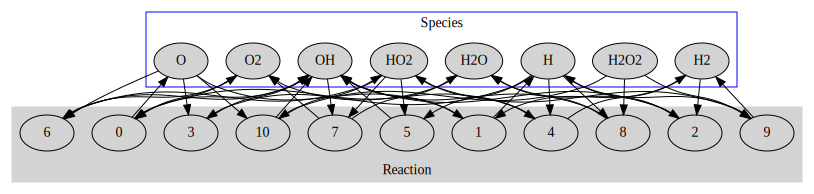

In [4]:
# Testing Bipartite Graph

bipartite = Digraph(comment='Bipartite Graph')
with bipartite.subgraph(name='cluster_1') as c:
    c.attr(style='filled')
    c.attr(label='Reaction', labelloc = 'b')
    c.attr(color='lightgrey')
    for idx, r in enumerate(reactions):
        c.node(str(idx))
        
with bipartite.subgraph(name='cluster_0') as c:
    c.node_attr.update(style='filled')
    c.attr(color='blue')
    c.attr(label='Species')
    for s in species:
        c.node(s)
        
for idx, r in enumerate(reactions):
    for k1 in r.getReactants():
        bipartite.edge(k1, str(idx))
    for k2 in r.getProducts():
        bipartite.edge(str(idx), k2)
    
# Print the graph
bipartite

In [60]:
# Defining Style

styles = {
    'graph': {
        'fontsize': '16',
        'fontcolor': 'white',
        'bgcolor': '#333333',
        'rankdir': 'BT',
        'pad':'1'
    },
    'nodes': {
        'fontname': 'Helvetica',
        'shape': 'octagon',
        'fontcolor': 'white',
        'color': 'white',
        'style': 'filled',
        'fillcolor': 'black',
    },
    'edges': {
        'style': 'dashed',
        'color': 'white',
        'arrowhead': 'open',
        'fontname': 'Courier',
        'fontsize': '12',
        'fontcolor': 'white',
    }
}


H is more reactant than product
O is more reactant than product
OH is more product than reactant
H2 is more reactant than product
H2O is more product than reactant
O2 is more product than reactant
HO2 is more reactant than product
H2O2 is pure product
top.graph_attr {'fontsize': '16', 'fontcolor': 'white', 'bgcolor': '#333333', 'rankdir': 'LR', 'pad': '1', 'ranksep': '2'}
top.node_attr {'fontname': 'Helvetica', 'shape': 'octagon', 'fontcolor': 'white', 'color': 'white', 'style': 'filled', 'fillcolor': 'black'}
{'fontsize': '16', 'fontcolor': 'white', 'bgcolor': '#333333', 'rankdir': 'LR', 'pad': '1', 'ranksep': '2'}
digraph "Product graph" {
	graph [rank=max]
	H2O2
}


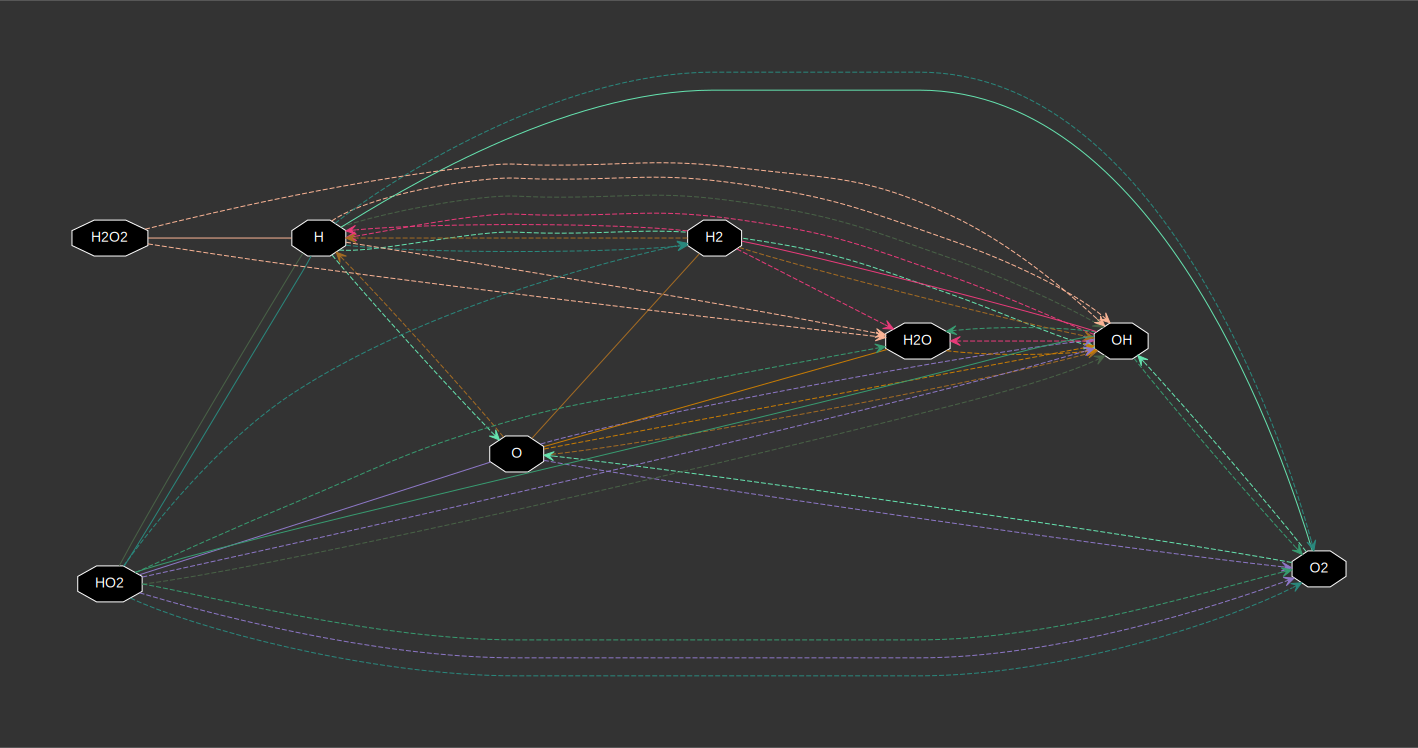

In [89]:
top = Digraph('Top graph',comment='Hierarchical Graph')
high = Digraph('Reactant graph')
low = Digraph('Product graph')
midhigh = Digraph('Reactant graph')
midlow = Digraph('Product graph')

high.graph_attr.update(rank='source')
midhigh.graph_attr.update(rank='source')
midlow.graph_attr.update(rank='min')
low.graph_attr.update(rank='max')

reactant_count = {s:0 for s in species}
product_count = {s:0 for s in species}

def is_reactant(s):
    for r in reactions:
        if s in r.getReactants().keys():
            return True

def is_product(s):
    for r in reactions:
        if s in r.getProducts().keys():
            return True

for s in species:
    for r in reactions:
        if s in r.getReactants().keys():
            reactant_count[s]+=1
        if s in r.getProducts().keys():
            product_count[s]+=1
top.graph_attr.update(styles['graph'])
top.node_attr.update(styles['nodes'])
top.edge_attr.update(styles['edges'])
top.graph_attr.update(rankdir='LR')
top.graph_attr.update(ranksep='2')
# top.graph_attr.update( rank = 'min')   #rankdir='LR',
# bot.graph_attr.update( rank = 'min')
# top.graph_attr.update(('graph' in styles and styles['graph']) or {})


# top.node_attr.update(newrank = 'True')
# top.node_attr.update(rank = 'same')
# print('reactant_count,product_count',reactant_count,product_count)
for s in species:
#     print(s)
#     print('reactant_count[s],product_count[s]',reactant_count[s],product_count[s])
    if reactant_count[s] == 0:
        print(s,'is pure reactant')
        high.node(s)
    elif product_count[s] == 0:
        print(s,'is pure product')
        low.node(s)
    elif reactant_count[s] >= product_count[s]:
        print(s,'is more reactant than product')
        midhigh.node(s)
    elif reactant_count[s] < product_count[s]:
        print(s,'is more product than reactant')
        midlow.node(s)

random.seed(2017)
graphics = {}
for r in reactions[:9]:
    color = '#%02X%02X%02X' % (random.randint(0,255),random.randint(0,255),random.randint(0,255))
#     print(color)
    graphics['color'] = color
    for idx, k1 in enumerate(r.getReactants().keys()):
        for i,k in enumerate( r.getProducts() ):
            top.edge(k1, k,  color = color)
        for jdx, k2 in enumerate(r.getReactants().keys()):
            if k1 != k2 and jdx > idx:
                top.edge(k1, k2, arrowhead = 'none', color = color, style = 'filled')   
                
#top.graph_attr.update(('edges' in styles and styles['edges']) or {})
top.subgraph(high)
top.subgraph(midhigh)
top.subgraph(midlow)
top.subgraph(low)
# high.node_attr.update(rank = 'same')  
# midhigh.node_attr.update(rank = 'same')  
# midlow.node_attr.update(rank = 'same')   
# low.node_attr.update(rank = 'same')    
# top.node_attr.update(rank = 'same')
print('top.graph_attr',top.graph_attr)
print('top.node_attr',top.node_attr)
print(top.graph_attr)
print(low)
top

In [33]:
('edges' in styles and styles['edges']) or {}

{'arrowhead': 'open',
 'color': 'white',
 'fontcolor': 'white',
 'fontname': 'Courier',
 'fontsize': '12',
 'style': 'dashed'}

In [91]:
#%%file HierarchicalRSGraph.py

# Class for Hierarchical graph

class HierarchicalRSGraph():
    """
    This class generates a graph to visualize one or multiple reactions. The graph assigns a color to each equation 
    (can be defined by the user) and can show concentration of a given specie in the set of reactions by size of the node.
    The reactions can be plotted all at once or separately, with different grouping options and style options.
    
    ATTRIBUTES
    ==========
    reac_system: ReactionSystem object to represent.
    target_file: Optional. File path indicating where to save the generated graph.
    
    METHODS
    =======
    
    
    
    EXAMPLES
    ========
    >>> rs = ReactionSystem(reactions)
    >>> h_graph = HierarchicalRSGraph(rs)
    >>> h_graph.view(method='jupyter')   # Displays on a jupyter notebook without saving to pdf
    
    """
    
    default_style = {
        'graph': {
            'fontsize': '16',
            'fontcolor': 'white',
            'bgcolor': '#333333',
            'rankdir': 'BT',
            'pad':'1'
        },
        'nodes': {
            'fontname': 'Helvetica',
            'shape': 'octagon',
            'fontcolor': 'white',
            'color': 'white',
            'style': 'filled',
            'fillcolor': 'black',
        },
        'edges': {
            'style': 'dashed',
            'color': 'white',
            'arrowhead': 'open',
            'fontname': 'Courier',
            'fontsize': '12',
            'fontcolor': 'white',
        }
    }
    
    
    def __init__(self,reaction_sys,format="pdf",style=None):
        self.rs = reaction_sys
        self.initialize_top_graph(format,style)
            
    def initialize_top_graph(self, format="pdf", style = None):
        self.top = Digraph(format = format)
        if style == None:
            self.change_style(default_style)
        else:
            self.change_style(style)
        
    def build_reaction_graph(self, reaction, prefix = "cluster", color = None):
        """
        Builds a graph for one reaction.
        """
        
        if color == None:
            color = get_random_color()
            
        r_graph = Digraph(prefix+'Reaction')
        r_graph.graph_attr.update(label = reaction.get_reaction_equation())
        
        for s in reaction.get_species():
            r_graph.node(s)
            
        self.set_edges(reaction, color)
            
        return r_graph
    
        
    def get_random_color(self):
        """
        Generates a random hexadecimal color.
        """
        return '#%02X%02X%02X' % (random.randint(0,255),random.randint(0,255),random.randint(0,255))
    
        
    def plot_reactions(self, method = 'jupyter', path = "", idxs = []):
        """
        Plots individual graphs for each reaction in the ReactionSystem.
        """
        
        if not idxs:
            idxs = range(len(self.rs.get_reactions()))
        for i,r in enumerate(self.rs.get_reactions()):
            if i in idxs:
                r_graph = build_reaction_graph(r,prefix = 'cluster')
                self.top.subgraph(r_graph)
                r_graph.graph_attr.update(rank='same')
        
        self.plot(method = method, path=path)
        
            
    def change_style(self, style):
        """
        Changes the style of the top graph. Input style should be a dictionary with 3 sub-dictionaries:
        one for graph, one for nodes and one for edges.
        """
        top.graph_attr.update(('graph' in styles and styles['graph']) or {})
        top.node_attr.update(('nodes' in styles and styles['nodes']) or {})
        top.edge_attr.update(('edges' in styles and styles['edges']) or {})
        

    def plot(self,method='format',path=""):
        """
        Displays current top graph in jupyter or pdf version. If pdf selected, also saves the image. 
        If no path has been specified, the image is saved in the current directory.
        """
        if method == 'jupyter':
            self.top
        elif method == 'format':
            self.top.view()
        else:
            raise ValueError('Unknown method. Valid methods are "jupyter" or "pdf".')
            
    
    def plot_system(self,method='jupyter',path=""):
        """
        Plots the Reaction system as a whole, without separation between reactions. Shows how each specie interacts 
        In the full reaction system. If the amount of reactions in the system is less than 4, the plot will be generated
        With 2 columns of species, representing on the left the species that are more reactant than product, and on the right
        the species that are more product than reactant. If the system has more than 4 reactions, an automatic organization
        of nodes is performed instead.
        """
        self.initialize_top_graph()
        
        self.top.graph_attr.update(rankdir='LR')
        
        if len(self.rs.get_reactions()) <=4:
            self.top.graph_attr.update(ranksep='2')
            reac = Digraph('Reactant graph')
            prod = Digraph('Product graph')
            reactant_count = {}
            product_count = {}
            for s in self.rs.get_species():
                for r in self.rs.get_reactions():
                    if s in r.getReactants().keys():
                        reactant_count[s]+=1
                    if s in r.getProducts().keys():
                        product_count[s]+=1
            for s in self.rs.get_species():
                if reactant_count[s] == 0:
                    reac.node(s)
                elif product_count[s] == 0:
                    prod.node(s)
                elif reactant_count[s] >= product_count[s]:
                    reac.node(s)
                elif reactant_count[s] < product_count[s]:
                    prod.node(s)
            reac.node_attr.update(rank = 'same')
            prod.node_attr.update(rank = 'same')
            top.subgraph(reac)
            top.subgraph(prod)
            
        else:
            for s in self.rs.get_species():
                self.top.node(s)
        
        for reaction in self.rs.get_reactions():
            color = get_random_color()
            self.set_edges(reaction, color)
    
        self.plot(method=method, path=path)
        
        
    def save_evolution_mp4(self,system,reactions,timesteps=5, path = ""):
        
        for n in range(timesteps):
            self.rs.concentration_step()
            imgs.append(self.plot_system())
        
        self.save_gif(imgs)
    
    def set_edges(self, reaction, color):
        for idx, r1 in enumerate(reaction.getReactants().keys()):
            for r2 in reaction.getProducts().keys():
                if reaction.is_reversible():
                    r_graph.edge(r1, r2, arrowhead = 'none', color = color)
                else:
                    r_graph.edge(r1, r2, color = color)
            for jdx, r2 in enumerate(reaction.getReactants().keys()):
                if r1 != r2 and jdx > idx:
                    top.edge(k1, k2, arrowhead = 'none', color = color, style = 'filled') 
                    
    def save_mp4(self,imgs, path):
        frames = [ImageClip(img).set_duration(0.1) for img in imgs]
        movie = concatenate_videoclips(frames, method="compose")
        movie.write_videofile(path+".mp4", fps=30)

    

SyntaxError: invalid syntax (<ipython-input-91-4ad0a982b668>, line 81)

In [ ]:
# Testing

def test_plot_system_on_notebook():
    pass

def test_plot_system_pdf():
    pass
    
def test_plot_reactions_notebook():
    pass

def test_plot_reactions_pdf():
    pass

def test_evolution_mp4():
    pass

def test_wrong_plot_method():
    pass

def test_changing_styles():
    pass

def test_plot_system_more_than_4_reactions():
    pass